# How to use mcFano feature selection tool

In [35]:
import scanpy as sc

from BigSur.feature_selection import mcfano_feature_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sc.set_figure_params(dpi=100)

## Setup adata

In [2]:
adata = sc.read_10x_h5('../../../Data/10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in adata

/Users/emmanueldollinger/miniconda3/envs/FanoFeatureSelection/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/emmanueldollinger/miniconda3/envs/FanoFeatureSelection/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata.var_names_make_unique()

In [4]:
adata.layers['counts'] = adata.X.copy()

## Checks for adata input

Default usage: specify adata and layer of counts

We require filtering genes before usage:

In [5]:
mcfano_feature_selection(adata, layer='counts')

Only using pvalue cutoff 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile for highly variable genes


Exception: Zero means were found, run QC steps before calculating mFF.

In [6]:
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
adata.shape

(11893, 22300)

In [8]:
adata.layers['counts'] = adata.X.copy()

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

We require passing counts, not normalized data:

In [10]:
mcfano_feature_selection(adata, layer='X')

Only using pvalue cutoff 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile for highly variable genes


Exception: This function takes raw counts, normalized data was passed.

Default scanpy pipeline:

In [13]:
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

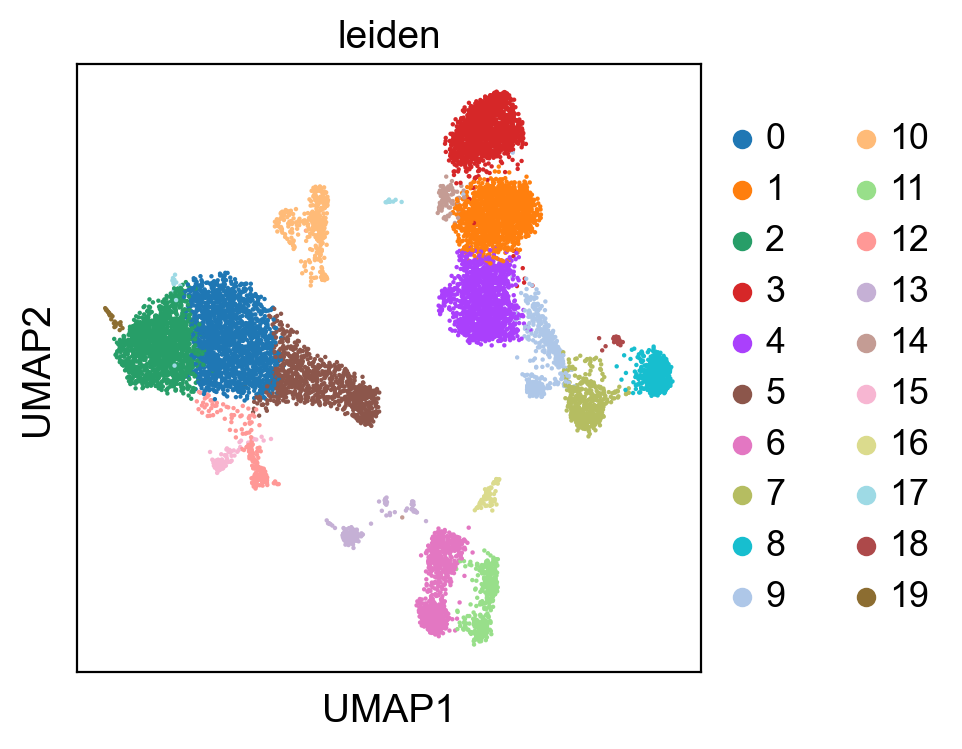

In [14]:
sc.pl.umap(adata, color='leiden')

Default mcFano usage:

In [15]:
mcfano_feature_selection(adata, layer='counts') # Replace sc.pp.highly_variable_genes(adata) call
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Only using pvalue cutoff 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile for highly variable genes


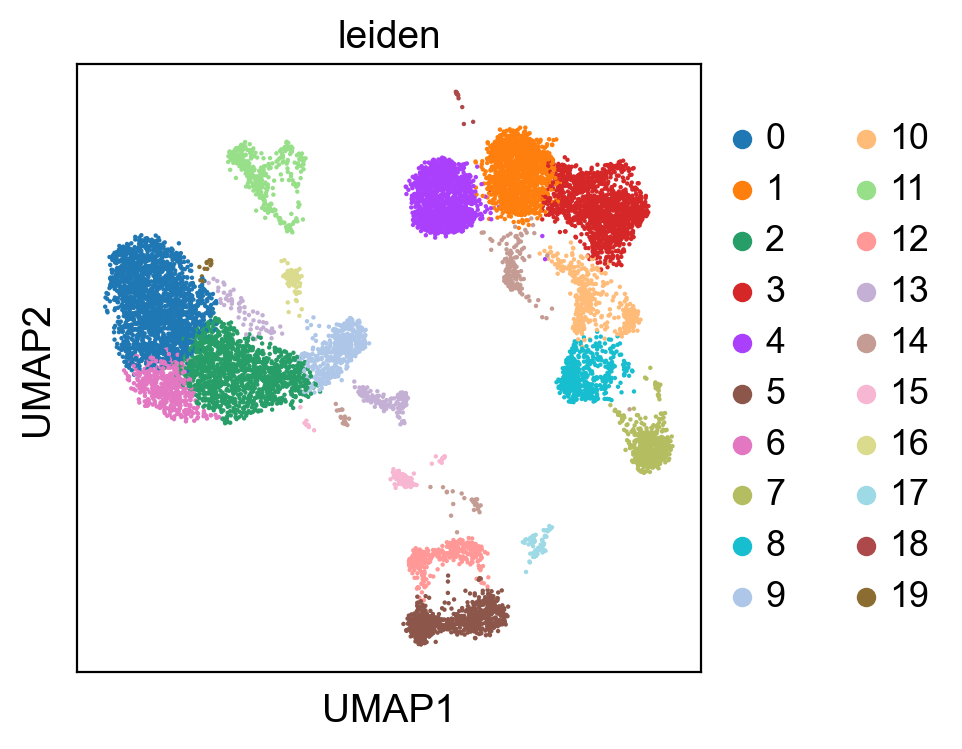

In [16]:
sc.pl.umap(adata, color='leiden')

## Advanced usage:

### Tool has 3 verbosity levels: none, a little and a lot

In [17]:
mcfano_feature_selection(adata, layer='counts', verbose=0)

In [18]:
mcfano_feature_selection(adata, layer='counts', verbose=1)

Only using pvalue cutoff 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile for highly variable genes


In [19]:
mcfano_feature_selection(adata, layer='counts', verbose=2)

Only using pvalue cutoff 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile for highly variable genes
Calculating corrected Fano factors.
Finished calculating corrected Fano factors for 22300 genes in 2.783161 seconds.
Setting min_fano to 1.74010412831477
Calculating p-values.
Finished calculating p-values for 1115 corrected Fano factors in 1.495262 seconds.
Setting 1045 genes with p-values below 0.05 and Fano factors above 1.74010412831477 as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HIST1H2AC' 'HOPX'
 'IFI27' 'IGHA1' 'IGHD' 'IGHG1' 'IGHG2' 'IGHG3' 'IGHG4' 'IGHM' 'IGHV3-15'
 'IGKC' 'IGKV1-39' 'IGKV1-9' 'IGKV4-1' 'IGLC1' 'IGLC2' 'IGLC3' 'IGLC6'
 'IGLC7' 'IGLV1-44' 'IGLV1-51' 'IGLV2-23' 'IGLV2-8' '

### User can pick whether to limit the number of genes called as highly variable:

In [20]:
mcfano_feature_selection(adata, layer='counts', verbose=1, n_genes_for_PCA=400)

Using pvalue cutoff of 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile and top 400 genes for highly variable genes


In [21]:
adata.var['highly_variable'].sum()

400

Note that by default if there is a conflict between the cutoffs and the number of genes requested by the user, the cutoffs win:

In [22]:
mcfano_feature_selection(adata, layer='counts', verbose=1, n_genes_for_PCA=10000)

Using pvalue cutoff of 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile and top 10000 genes for highly variable genes


/Users/emmanueldollinger/Documents/Projects/FeatureSelectionMethod/Code/bigsur_public/BigSur/BigSur/feature_selection.py:151: UserWarning: Number of genes meeting cutoffs (1045) is lower than user requested genes (10000). Only including genes meeting cutoff in "highly_variable" slot.
  warnings.warn(


In [23]:
adata.var['highly_variable'].sum()

1045

The p value cutoff can be disabled:

In [24]:
mcfano_feature_selection(adata, layer='counts', verbose=1, p_val_cutoff=None)

Only using min fano quantile cutoff of 0.95 for highly variable genes


We do NOT recommend turning off the p value criterion; however if considering different celltypes, p value cutoff isn't necessary (and can be faster computationally): 

In [25]:
mcfano_feature_selection(adata, layer='counts', verbose=2)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Only using pvalue cutoff 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile for highly variable genes
Calculating corrected Fano factors.
Finished calculating corrected Fano factors for 22300 genes in 2.747687 seconds.
Setting min_fano to 1.74010412831477
Calculating p-values.
Finished calculating p-values for 1115 corrected Fano factors in 1.488530 seconds.
Setting 1045 genes with p-values below 0.05 and Fano factors above 1.74010412831477 as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HIST1H2AC' 'HOPX'
 'IFI27' 'IGHA1' 'IGHD' 'IGHG1' 'IGHG2' 'IGHG3' 'IGHG4' 'IGHM' 'IGHV3-15'
 'IGKC' 'IGKV1-39' 'IGKV1-9' 'IGKV4-1' 'IGLC1' 'IGLC2' 'IGLC3' 'IGLC6'
 'IGLC7' 'IGLV1-44' 'IGLV1-51' 'IGLV2-23' 'IGLV2-8' '

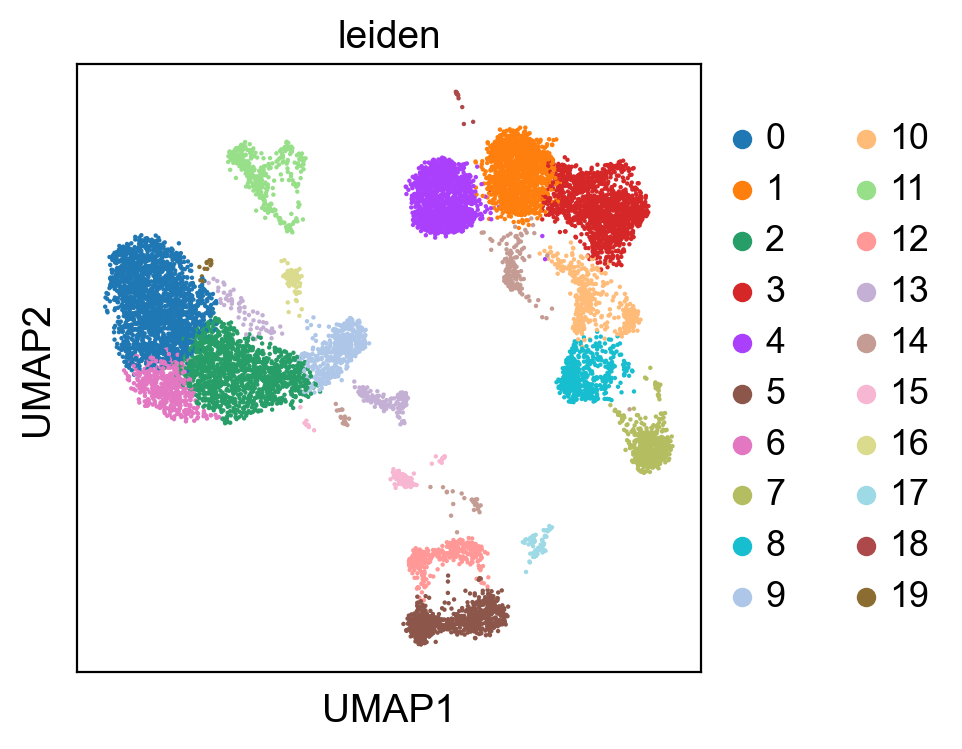

In [26]:
sc.pl.umap(adata, color='leiden')

In [27]:
mcfano_feature_selection(adata, layer='counts', p_val_cutoff=None, verbose=2)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

Only using min fano quantile cutoff of 0.95 for highly variable genes
Calculating corrected Fano factors.
Finished calculating corrected Fano factors for 22300 genes in 2.756421 seconds.
Setting min_fano to 1.74010412831477
Setting all genes with mcFano > 1.74010412831477 as highly variable.
Top 100 selected genes: 
 ['AC004554.2' 'AC005697.2' 'AC006372.1' 'AC009075.1' 'AC011997.1'
 'AC092611.1' 'AC092651.3' 'AC106743.1' 'AC109492.1' 'AC124242.3' 'ADAD2'
 'AGBL5-AS1' 'AICDA' 'AK5' 'AKAP6' 'AL022323.5' 'AL133330.2' 'AL158071.4'
 'AL354760.1' 'AL590705.1' 'AL592430.1' 'ALOX12' 'ANKK1' 'AREG' 'ATP7B'
 'ATP9A' 'BLNK' 'BRI3' 'C1orf229' 'C1orf56' 'CCR6' 'CD19' 'CD6' 'CD68'
 'CHI3L2' 'CLEC7A' 'CLLU1OS' 'COL1A1' 'CPNE7' 'CYP4F8' 'FCGR2A' 'FLT3LG'
 'FOXD2-AS1' 'GAPT' 'GATA3' 'GATA3-AS1' 'GBP4' 'GPR171' 'GPR68' 'HPGDS'
 'IGLV3-19' 'ITK' 'KCNQ2' 'KLHL29' 'LDLRAP1' 'LGALS3' 'LINC00662' 'MPP1'
 'MYB' 'NAV2-AS3' 'NPDC1' 'OR2G6' 'PDGFB' 'PTGS2' 'PTTG1' 'RDH16' 'RPRML'
 'RPS27' 'RPS5' 'RPSA' 'S100A10'

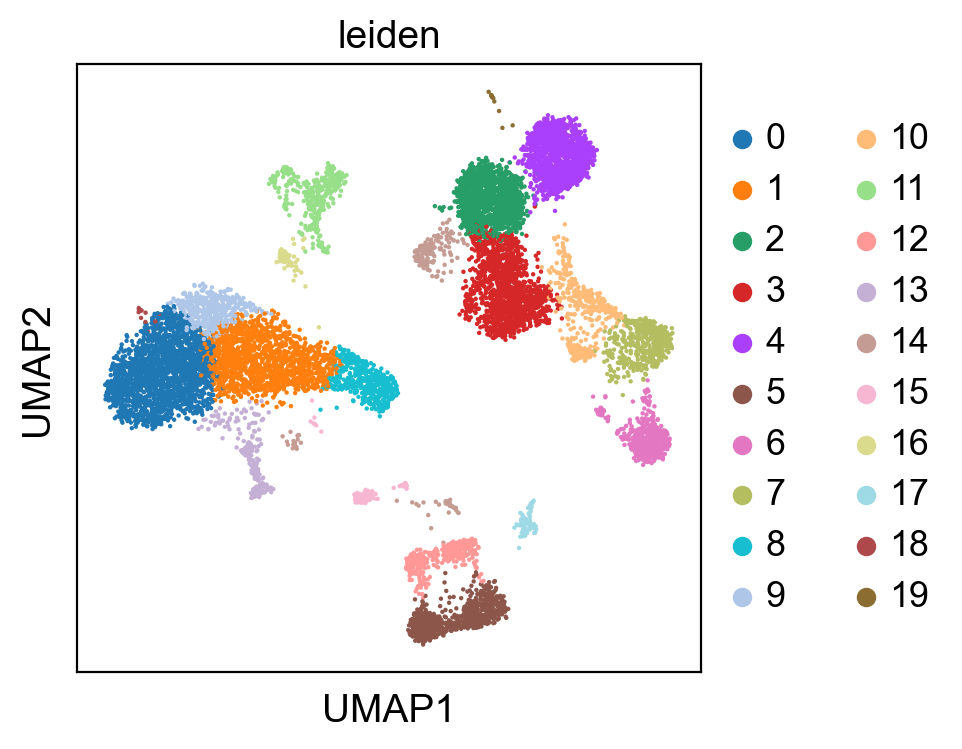

In [28]:
sc.pl.umap(adata, color='leiden')

UMAPs are similar

### Fitting coefficient of variation

CV is the only parameter in our model. We've found that using a CV of 0.5 is usually sufficient, but we also provide a way to fit CV:

In [31]:
PBMC=sc.read('../../../Data/10kPBMC_working.h5ad')

PBMC.uns['log1p']['base'] = None

Only using pvalue cutoff 0.05 and calculating pvalues for genes with mcFano factor that are 0.95 quantile for highly variable genes


/var/folders/dr/316t0vqd63z7qmsd6j37nb8m0000gn/T/ipykernel_66028/2063519532.py:17: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df['Cutoff'].cat.reorder_categories(['Below 0.001', 'Between 0.001 and 0.01', 'Between 0.01 and 0.05','Greater than 0.05' ], inplace=True)


Text(0.5, 1.0, 'mcFano vs mean (CV = 0.35)')

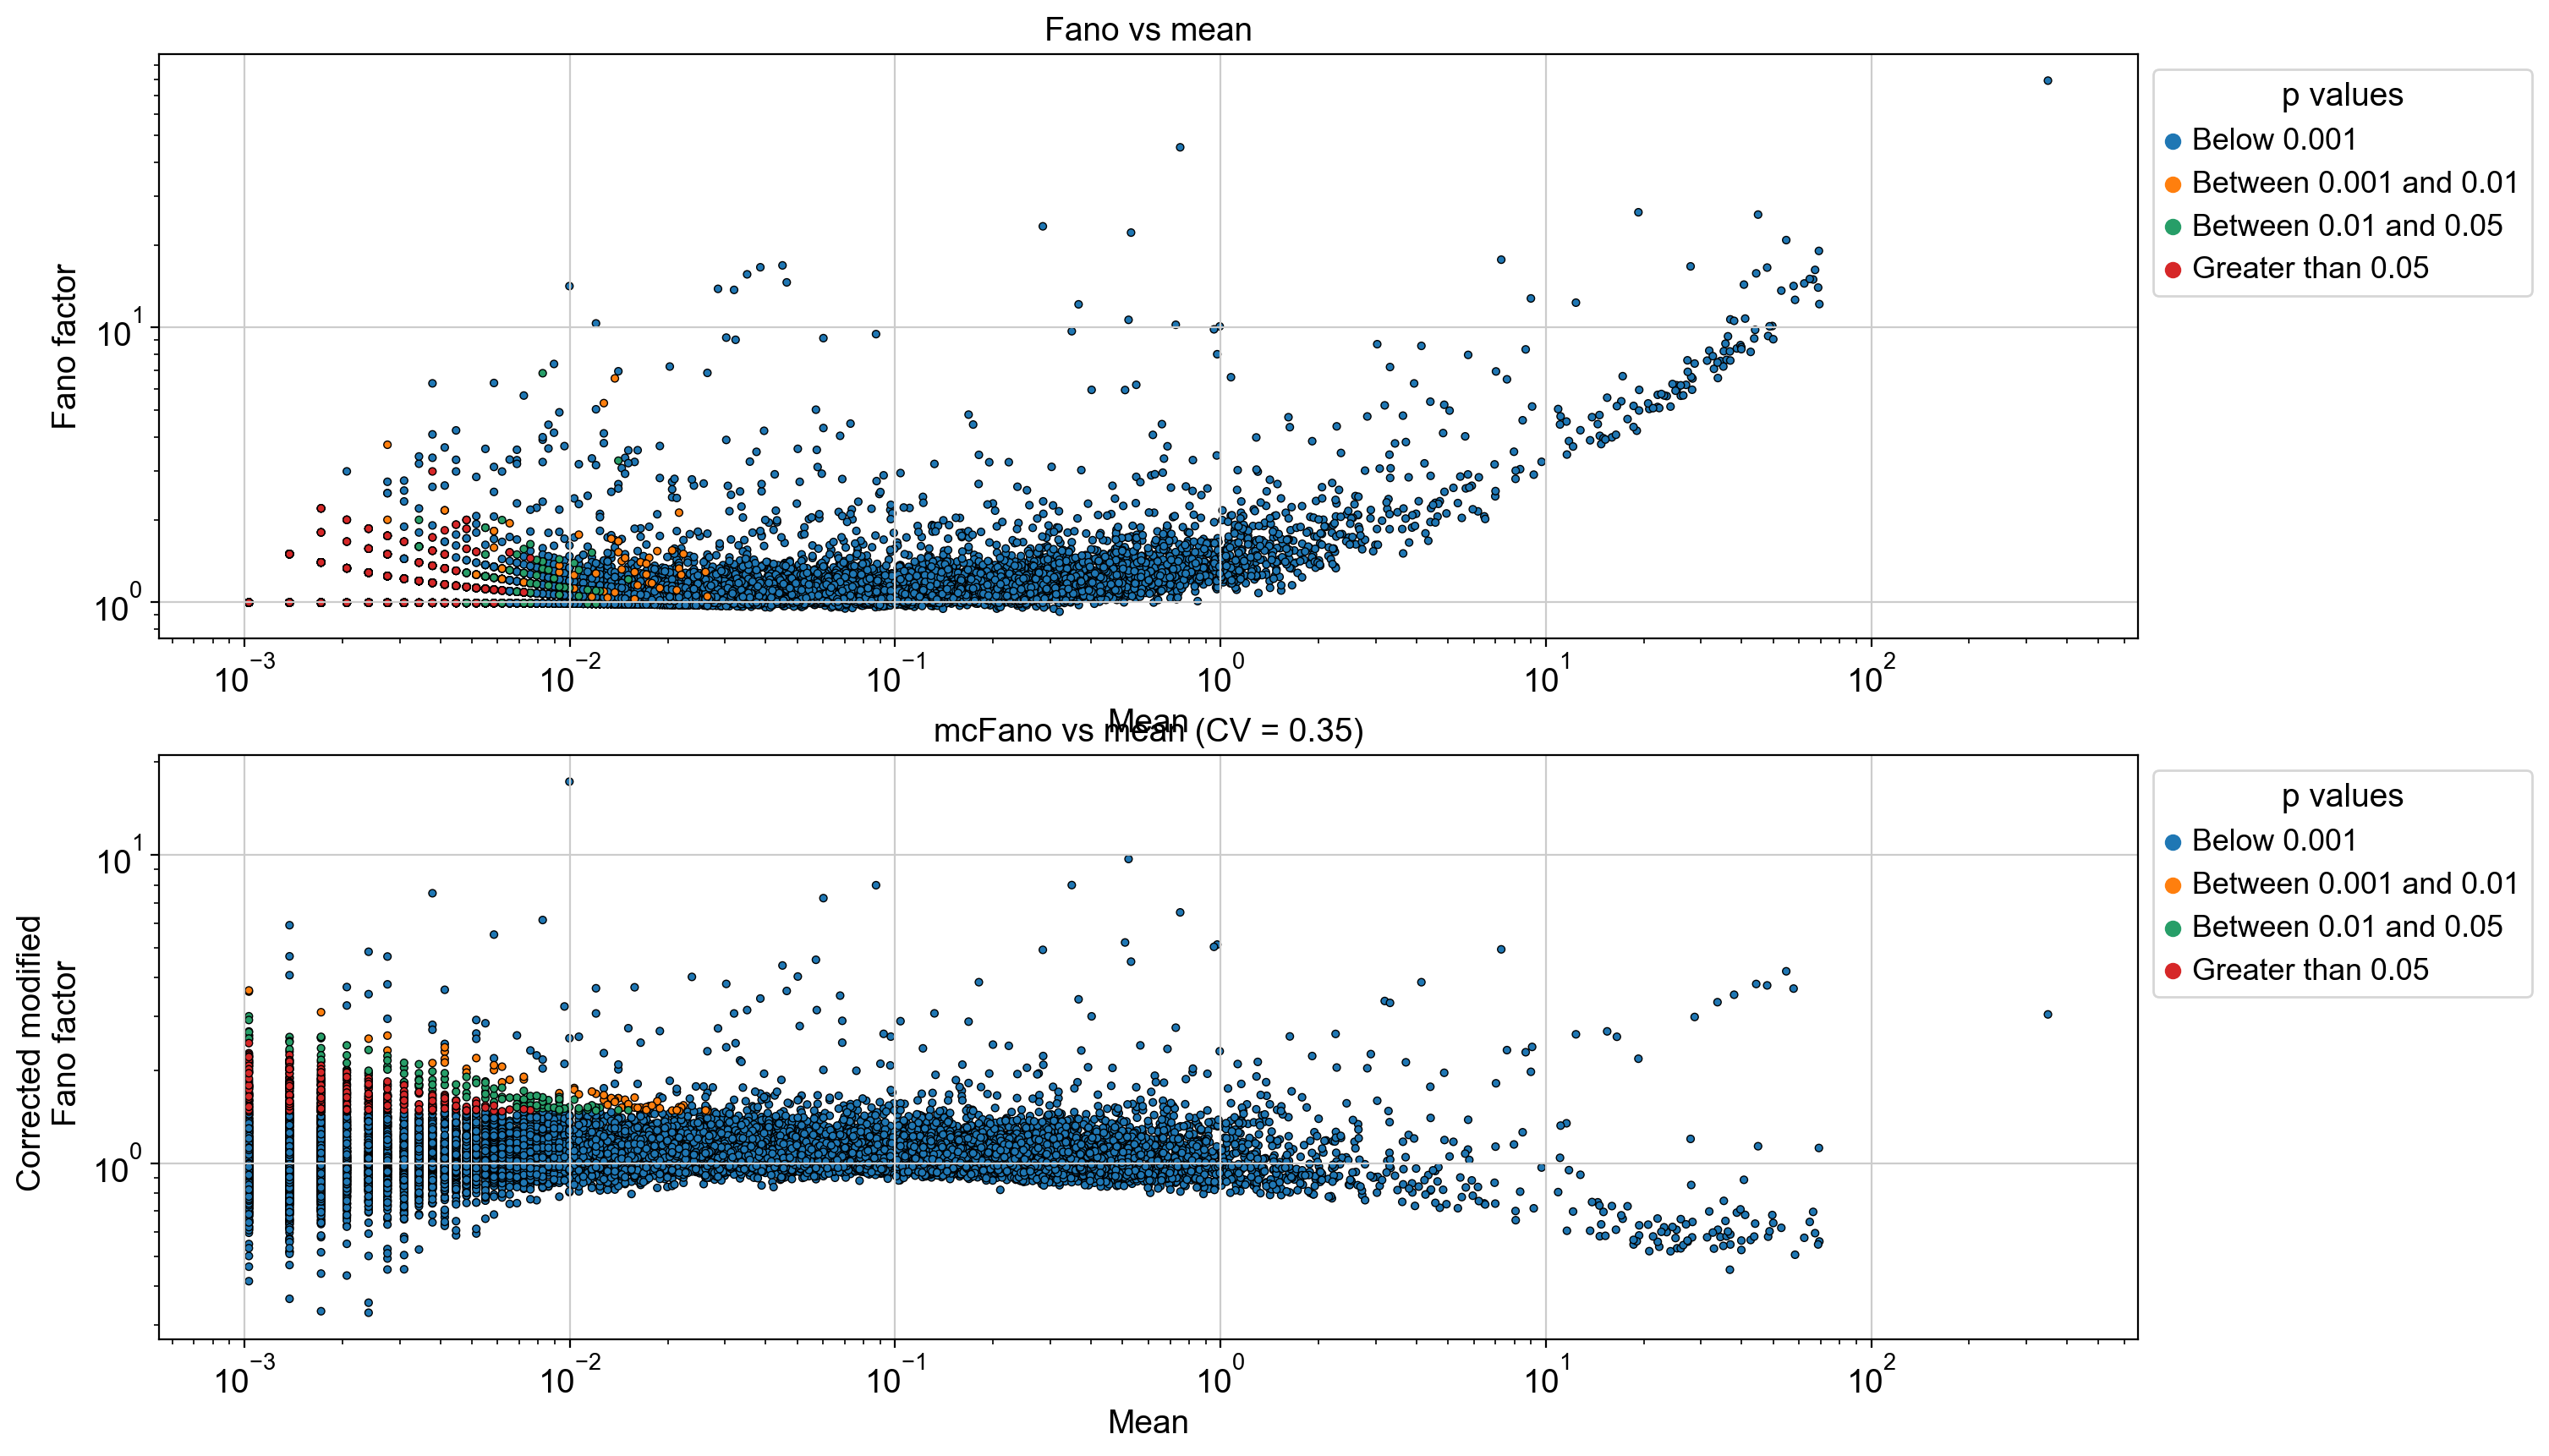

In [37]:
CD4 = PBMC[PBMC.obs['GroupedIdents'].isin(['CD4+ T Cells'])].copy()

sc.pp.filter_genes(CD4, min_cells=3)
mcfano_feature_selection(CD4, layer='counts', cv=None) # Fit CV
cv = CD4.uns['CV_for_mc_Fano_fit'].astype(str)

means = np.array( CD4.layers['counts'].mean(axis=0) ).flatten()
var =  np.var(CD4.layers['counts'].toarray() ,axis=0 ).flatten()

df = CD4.var[['p-value', 'mc_Fano']].copy()
df['Fano'] = var/means
df['Cutoff'] = 'Below 0.001'
df.loc[df['p-value'] > 0.001,'Cutoff'] = 'Between 0.001 and 0.01'
df.loc[df['p-value'] > 0.01,'Cutoff'] = 'Between 0.01 and 0.05'
df.loc[df['p-value'] > 0.05,'Cutoff'] = 'Greater than 0.05'
df['Cutoff'] = df['Cutoff'].astype('category')
df['Cutoff'].cat.reorder_categories(['Below 0.001', 'Between 0.001 and 0.01', 'Between 0.01 and 0.05','Greater than 0.05' ], inplace=True)
df['Mean'] = means

df['Cutoff'] = df['Cutoff'].astype(str) 

#Fix hue plot order
order = ['Greater than 0.05',  'Below 0.001',  'Between 0.001 and 0.01','Between 0.01 and 0.05',]
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
for i, cutoff in enumerate(np.unique(df['Cutoff'])):

    sns.scatterplot(data=df[df['Cutoff'] == cutoff], y='Fano', x='Mean', hue='Cutoff', edgecolor='black', linewidth=0.5, s=10, palette=sns.color_palette()[i:i+1])
#sns.scatterplot(data=df[df['Cutoff'] == 'Greater than 0.05'], y='Mod_Fano', x='Mean', hue='Cutoff', edgecolor='black', linewidth=0.5, s=10, palette=sns.color_palette()[3:4])
#sns.scatterplot(data=df[df['DEGs']], y='Mod_Fano', x='Mean', color=sns.color_palette()[4:5], edgecolor='black', linewidth=0.5, s=100, label='Differentially expressed genes')
plt.legend(bbox_to_anchor=(1,1), title='p values')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Fano factor')
plt.title(f'Fano vs mean')

plt.subplot(2,1,2)
for i, cutoff in enumerate(np.unique(df['Cutoff'])):

    sns.scatterplot(data=df[df['Cutoff'] == cutoff], y='mc_Fano', x='Mean', hue='Cutoff', edgecolor='black', linewidth=0.5, s=10, palette=sns.color_palette()[i:i+1])
#sns.scatterplot(data=df[df['Cutoff'] == 'Greater than 0.05'], y='Mod_Fano', x='Mean', hue='Cutoff', edgecolor='black', linewidth=0.5, s=10, palette=sns.color_palette()[3:4])
#sns.scatterplot(data=df[df['DEGs']], y='Mod_Fano', x='Mean', color=sns.color_palette()[4:5], edgecolor='black', linewidth=0.5, s=100, label='Differentially expressed genes')
plt.legend(bbox_to_anchor=(1,1), title='p values')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Corrected modified \n Fano factor')
plt.title(f'mcFano vs mean (CV = {cv})')    

In [38]:
?mcfano_feature_selection

Signature:
mcfano_feature_selection(
    adata: anndata._core.anndata.AnnData,
    layer: str,
    cv: Union[bool, float] = 0.5,
    n_genes_for_PCA: Union[bool, int] = False,
    min_mcfano_cutoff: float = 0.95,
    p_val_cutoff: Union[bool, float] = 0.05,
    return_residuals: bool = False,
    verbose: int = 1,
)
Docstring:
Calculate the corrected Fano factor for all genes in the dataset. mc_Fano column will be added to .var. Highly_variable column will be added to .var based on the n_genes_for_pca and cutoff parameters.

Parameters
----------
adata - adata object containing information about the raw counts and gene names.
layer - String, describing the layer of adata object containing raw counts (pass "X" if raw counts are in adata.X).
cv - Float, coefficient of variation for the given dataset. If one is not supplied, one will be estimated.
n_genes_for_PCA - [Int, Bool], top number of genes to use for PCA, ranked by corrected modified Fano factor. If False, use p_val_cutoff and min

Package list:

In [39]:
!cat environment.yml

name: FanoFeatureSelection
channels:
  - anaconda
  - bioconda
  - conda-forge
  - defaults
dependencies:
  - _r-mutex=1.0.1=anacondar_1
  - adjusttext=0.7.3.1=py_1
  - alabaster=0.7.13=pyhd8ed1ab_0
  - anndata=0.8.0=pyhd8ed1ab_1
  - anndata2ri=1.1=pyhdfd78af_0
  - anyio=3.6.2=pyhd8ed1ab_0
  - aom=3.5.0=hf0c8a7f_0
  - applaunchservices=0.3.0=pyhd8ed1ab_2
  - appnope=0.1.3=pyhd8ed1ab_0
  - argon2-cffi=21.3.0=pyhd8ed1ab_0
  - argon2-cffi-bindings=21.2.0=py310h90acd4f_3
  - arpack=3.7.0=hefb7bc6_2
  - arrow=1.2.3=pyhd8ed1ab_0
  - astroid=2.13.3=py310h2ec42d9_0
  - atomicwrites=1.4.1=pyhd8ed1ab_0
  - attrs=22.2.0=pyh71513ae_0
  - autopep8=1.6.0=pyhd8ed1ab_1
  - babel=2.11.0=pyhd8ed1ab_0
  - backcall=0.2.0=pyh9f0ad1d_0
  - backports=1.0=pyhd8ed1ab_3
  - backports.functools_lru_cache=1.6.4=pyhd8ed1ab_0
  - beautifulsoup4=4.11.1=pyha770c72_0
  - binaryornot=0.4.4=py_1
  - bioconductor-biobase=2.54.0=r41h3be46a4_2
  - bioconductor-biocgenerics=0.40.0=r41hdfd78af_0
  - bioconductor-delayedarray